# Interactive Int'l District Vent Coordinate Picker (UTM Projection)

Click on the 1cm resolution International District map to pick vent locations.
Map uses UTM Zone 9N projection for correct aspect ratio.
Clicked coordinates are reported in both UTM (easting/northing) and lon/lat.

- **Left-click** to add a point
- **Right-click** to remove last point

## Pick order

| Pick # | Vent      | Notes                              |
|--------|-----------|------------------------------------|
| 1      | El Guapo  | High-temp, ~341°C                  |
| 2      | Escargot  | High-temp                          |
| 3      | Castle    | High-temp                          |
| 4      | Diva      | High-temp                          |
| 5      | Flat Top  | High-temp                          |

In [1]:
%matplotlib widget

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from pathlib import Path
import cartopy.crs as ccrs

# 1cm Int'l District bathymetry
BATHY_PATH = Path("/home/jovyan/my_data/axial/axial_bathy/MBARI_AxialSeamount_V2506_LASSlidar_IntlDist_Topo1cmSq.grd")

# Projections — UTM zone 9N (130°W falls in zone 9: 132°W–126°W)
UTM9N = ccrs.UTM(zone=9, southern_hemisphere=False)
LONLAT = ccrs.PlateCarree()

# Pick order
PICK_ORDER = ["El Guapo", "Escargot", "Castle", "Diva", "Flat Top"]

# Current vent locations (where known)
CURRENT_VENTS = {
    "El Guapo": {"lon": -129.979493, "lat": 45.926486},
    "Castle":   {"lon": -129.979996, "lat": 45.926218},
}

# Store picked points (in UTM coordinates)
picked_points = []
point_markers = []
point_labels = []

In [2]:
# Load 1cm Int'l District bathymetry and transform to UTM
print("Loading 1cm Int'l District bathymetry...")
ds = xr.open_dataset(BATHY_PATH)

x_lonlat = ds.coords['x'].values
y_lonlat = ds.coords['y'].values
z = ds['z'].values
ds.close()

# Build lon/lat meshgrid and transform to UTM
x_grid_ll, y_grid_ll = np.meshgrid(x_lonlat, y_lonlat)
pts_utm = UTM9N.transform_points(LONLAT, x_grid_ll, y_grid_ll)
x_utm_grid = pts_utm[:, :, 0]
y_utm_grid = pts_utm[:, :, 1]

# Get UTM extent from all four corners
corner_lons = np.array([x_lonlat.min(), x_lonlat.max(), x_lonlat.max(), x_lonlat.min()])
corner_lats = np.array([y_lonlat.min(), y_lonlat.min(), y_lonlat.max(), y_lonlat.max()])
corners_utm = UTM9N.transform_points(LONLAT, corner_lons, corner_lats)
x_utm_min, x_utm_max = corners_utm[:, 0].min(), corners_utm[:, 0].max()
y_utm_min, y_utm_max = corners_utm[:, 1].min(), corners_utm[:, 1].max()

print(f"Grid: {len(x_lonlat)} x {len(y_lonlat)} = {len(x_lonlat)*len(y_lonlat):,} points")
print(f"UTM Easting:  {x_utm_min:.1f} to {x_utm_max:.1f} m")
print(f"UTM Northing: {y_utm_min:.1f} to {y_utm_max:.1f} m")
print(f"Depth: {np.nanmin(z):.1f} to {np.nanmax(z):.1f} m")

Loading 1cm Int'l District bathymetry...
Grid: 15671 x 9126 = 143,013,546 points
UTM Easting:  423969.6 to 424127.8 m
UTM Northing: 5086262.6 to 5086395.3 m
Depth: -1527.1 to -1499.7 m


In [3]:
def utm_to_lonlat(easting, northing):
    """Convert UTM zone 9N coordinates back to lon/lat."""
    pt = LONLAT.transform_point(easting, northing, UTM9N)
    return pt[0], pt[1]

def on_click(event):
    """Handle mouse click events - coordinates are in UTM."""
    global picked_points, point_markers, point_labels, ax, fig

    if event.inaxes is None:
        return

    # Right-click to remove last point
    if event.button == 3:
        if picked_points:
            picked_points.pop()
            if point_markers:
                marker = point_markers.pop()
                marker.remove()
            if point_labels:
                label = point_labels.pop()
                label.remove()
            fig.canvas.draw()
            next_idx = len(picked_points)
            next_name = PICK_ORDER[next_idx] if next_idx < len(PICK_ORDER) else "done"
            print(f"Removed last point. Next pick: #{next_idx+1} {next_name}")
        return

    # Left-click to add point
    if event.button == 1:
        easting, northing = event.xdata, event.ydata
        lon, lat = utm_to_lonlat(easting, northing)
        pick_idx = len(picked_points)
        pick_name = PICK_ORDER[pick_idx] if pick_idx < len(PICK_ORDER) else f"Extra_{pick_idx+1}"
        picked_points.append((easting, northing, lon, lat))

        # Add small marker
        marker, = ax.plot(easting, northing, 'ro', markersize=4,
                          markeredgecolor='white', markeredgewidth=1, zorder=20)
        point_markers.append(marker)

        # Add label with pick number and name
        label = ax.annotate(f'{pick_idx+1}: {pick_name}', (easting, northing),
                            xytext=(10, 10), textcoords='offset points',
                            fontsize=9, fontweight='bold', color='red',
                            bbox=dict(boxstyle='round,pad=0.3',
                                     facecolor='white', alpha=0.9),
                            zorder=21)
        point_labels.append(label)

        fig.canvas.draw()
        print(f"Pick {pick_idx+1} ({pick_name}): E={easting:.1f} N={northing:.1f}  (lon={lon:.6f}, lat={lat:.6f})")
        next_idx = pick_idx + 1
        if next_idx < len(PICK_ORDER):
            print(f"  -> Next: #{next_idx+1} {PICK_ORDER[next_idx]}")
        else:
            print(f"  -> All {len(PICK_ORDER)} vents picked! Run the output cell.")

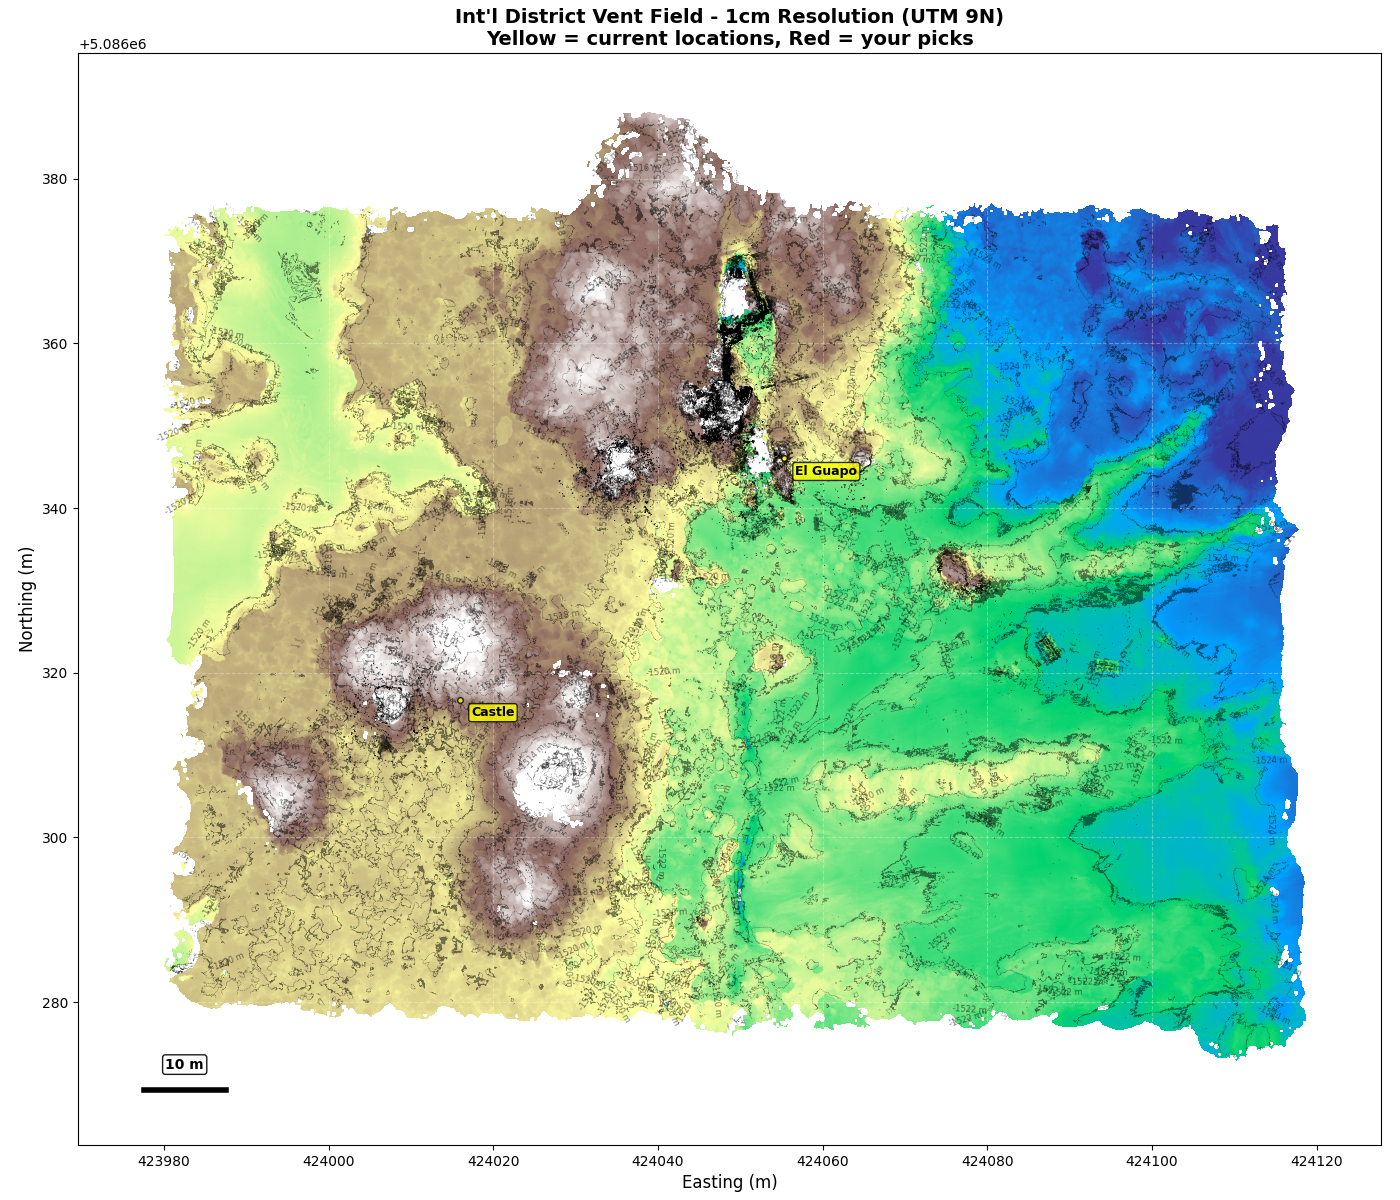

PICK ORDER:
  1. El Guapo (current location shown)
  2. Escargot (no prior coordinates)
  3. Castle (current location shown)
  4. Diva (no prior coordinates)
  5. Flat Top (no prior coordinates)
LEFT-CLICK to add points, RIGHT-CLICK to remove last point


In [4]:
# Create the interactive map in UTM projection
fig, ax = plt.subplots(figsize=(14, 12))

# Create shaded relief
ls = LightSource(azdeg=315, altdeg=35)
z_min, z_max = np.nanpercentile(z, [1, 99])
rgb = ls.shade(z, cmap=plt.cm.terrain, blend_mode='soft',
               vmin=z_min, vmax=z_max, vert_exag=2)

# Plot in UTM coordinates
ax.imshow(rgb, extent=[x_utm_min, x_utm_max, y_utm_min, y_utm_max],
          origin='lower', aspect='equal')

# Add depth contours in UTM
contour_levels = np.arange(-1530, -1498, 1)
cs = ax.contour(x_utm_grid, y_utm_grid, z, levels=contour_levels,
                colors='black', linewidths=0.3, alpha=0.5)
ax.clabel(cs, levels=contour_levels[::2], fontsize=6, fmt='%d m', inline=True)

# Plot current vent locations (where known) — yellow markers
for name in PICK_ORDER:
    if name in CURRENT_VENTS:
        info = CURRENT_VENTS[name]
        pt = UTM9N.transform_point(info['lon'], info['lat'], LONLAT)
        ax.plot(pt[0], pt[1], 'o', markersize=4,
                markerfacecolor='yellow', markeredgecolor='black',
                markeredgewidth=1, alpha=0.8, zorder=10)
        ax.annotate(name, (pt[0], pt[1]),
                    xytext=(8, -12), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='yellow',
                             alpha=0.8, edgecolor='black'),
                    zorder=11)

ax.set_xlabel('Easting (m)', fontsize=12)
ax.set_ylabel('Northing (m)', fontsize=12)
ax.set_title("Int'l District Vent Field - 1cm Resolution (UTM 9N)\n"
             'Yellow = current locations, Red = your picks',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--', color='white')

# Add 10m scale bar (exact in UTM meters)
scale_x = x_utm_min + (x_utm_max - x_utm_min) * 0.05
scale_y = y_utm_min + (y_utm_max - y_utm_min) * 0.05
ax.plot([scale_x, scale_x + 10], [scale_y, scale_y], 'k-', linewidth=4)
ax.text(scale_x + 5, scale_y + (y_utm_max - y_utm_min) * 0.02, '10 m',
        ha='center', fontsize=10, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.9))

# Connect click event
fig.canvas.mpl_connect('button_press_event', on_click)

plt.tight_layout()
plt.show()

print("="*60)
print("PICK ORDER:")
for i, name in enumerate(PICK_ORDER):
    status = " (current location shown)" if name in CURRENT_VENTS else " (no prior coordinates)"
    print(f"  {i+1}. {name}{status}")
print("="*60)
print("LEFT-CLICK to add points, RIGHT-CLICK to remove last point")

In [5]:
# Run this cell to see all picked coordinates
print("PICKED INT'L DISTRICT VENT COORDINATES")
print("=" * 60)
if picked_points:
    for i, (e, n, lon, lat) in enumerate(picked_points):
        name = PICK_ORDER[i] if i < len(PICK_ORDER) else f"Point_{i+1}"
        print(f"  {i+1}. {name}: E={e:.1f} N={n:.1f}  (lon={lon:.6f}, lat={lat:.6f})")

    print("\n# Copy this into make_intl_district_map.py:")
    print("VENTS = {")
    for i, (e, n, lon, lat) in enumerate(picked_points):
        name = PICK_ORDER[i] if i < len(PICK_ORDER) else f"Point_{i+1}"
        print(f'    "{name}": {{"lon": {lon:.6f}, "lat": {lat:.6f}, "type": "high-temp"}},')
    print("}")
else:
    print("No points picked yet. Click on the map above.")

PICKED INT'L DISTRICT VENT COORDINATES
  1. El Guapo: E=424048.3 N=5086352.4  (lon=-129.979585, lat=45.926543)
  2. Escargot: E=424076.1 N=5086332.3  (lon=-129.979223, lat=45.926365)
  3. Castle: E=424007.7 N=5086316.1  (lon=-129.980102, lat=45.926212)
  4. Diva: E=424085.2 N=5086333.5  (lon=-129.979105, lat=45.926377)
  5. Flat Top: E=424028.3 N=5086308.1  (lon=-129.979836, lat=45.926141)

# Copy this into make_intl_district_map.py:
VENTS = {
    "El Guapo": {"lon": -129.979585, "lat": 45.926543, "type": "high-temp"},
    "Escargot": {"lon": -129.979223, "lat": 45.926365, "type": "high-temp"},
    "Castle": {"lon": -129.980102, "lat": 45.926212, "type": "high-temp"},
    "Diva": {"lon": -129.979105, "lat": 45.926377, "type": "high-temp"},
    "Flat Top": {"lon": -129.979836, "lat": 45.926141, "type": "high-temp"},
}
